In [ ]:
!git clone https://github.com/federicozanini/NLP.git

Cloning into 'NLP'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 252 (delta 70), reused 92 (delta 24), pack-reused 87
Receiving objects: 100% (252/252), 320.74 MiB | 40.32 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
import tensorflow as tf 
import math

import os
import numpy as np
import pandas as pd
import json

In [ ]:
#df_preproc = pd.read_csv("./NLP/preprocessed_utildatas_new.csv")
df_train = pd.read_pickle("./NLP/FINAL_DATASETS/VERSION_IDX_BY_WORD/df_train.zip", compression='zip')
df_val = pd.read_pickle("./NLP/FINAL_DATASETS/VERSION_IDX_BY_WORD/df_val.zip", compression='zip')

In [ ]:
df_train.head()

,id,title,context,question,text,context_list,question_list,answer_list,answer_start,answer_end
0,56f8f96c9e9bad19000a0796,Near_East,until the period following world war i the nea...,what was simpson s pen name,weale,"[until, the, period, following, world, war, i,...","[what, was, simpson, s, pen, name]",[weale],74,74
1,570e78860dc6ce19002050bd,Melbourne,melbourne s live performance institutions date...,from what year does the sidney myer music bowl...,1955,"[melbourne, s, live, performance, institutions...","[from, what, year, does, the, sidney, myer, mu...",[1955],114,114
2,56f8e48f9e9bad19000a06ac,Near_East,by the time of john seller s atlas maritima of...,when was john seller s atlas maritima,1670,"[by, the, time, of, john, seller, s, atlas, ma...","[when, was, john, seller, s, atlas, maritima]",[1670],10,10
3,57264659708984140094c11d,Greece,the following era was marked by instability as...,how many greek refugees came from turkey,15 million,"[the, following, era, was, marked, by, instabi...","[how, many, greek, refugees, came, from, turkey]","[15, million]",9,10
4,56d9ca63dc89441400fdb828,Dog,there have been two major trends in the changi...,when a person shapes a dog to conform to his e...,commodification,"[there, have, been, two, major, trends, in, th...","[when, a, person, shapes, a, dog, to, conform,...",[commodification],19,19


In [ ]:
#### Parameters : #################

# BATCH SIZE
btch_size = 32

# LEARNING RATE
# we went for a medium value because we implemented the reducing-learningrate callback
lrn_rate = 0.01

# NUMBER OF EPOCHS
# we went for a surely exciding number of epochs because we implemented the early-stopping callback
n_epochs = 50

# RNN UNITS
rnn_units = 50

# DROPOUT
drp_out = 0.1

###################################

## Training function: 


In [ ]:
class CBACK(tf.keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(CBACK, self).__init__()
    self.patience = patience
    # best_weights to store the weights at which the minimum loss occurs.
    self.best_weights = None

  def on_train_begin(self, logs=None):
    # The number of epoch it has waited when loss is no longer minimum.
    self.wait = 0
    # The epoch the training stops at.
    self.stopped_epoch = 0
    # Initialize the best as infinity.
    self.best = -np.Inf

  def on_epoch_end(self, epoch, logs=None):
    current_start = logs.get("val_start_categorical_accuracy")
    current_end =  logs.get("val_end_categorical_accuracy")
    
    if np.less(self.best, (current_start+current_end)/2):
        self.best = (current_start+current_end)/2
        self.wait = 0
        print("categorical_accuracy improved!")
        self.best_weights = self.model.get_weights()
    else:
        self.wait += 1
        if self.wait >= self.patience:
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print("Restoring model weights from the end of the best epoch.")
            self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
        print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [ ]:
def train_model(folder, model, model_name, gen, df_val, batch, epochs, **kargs):
  
  # Path where the final model will be saved
  models_dir = os.path.join(folder, 'models')
  os.makedirs(models_dir, exist_ok = True)
  model_file = os.path.join(models_dir, model_name+".h5")

  history = model.fit(gen,
    epochs=epochs,
    validation_data = df_val,
    callbacks=[CBACK(patience = 5)])

  return history

In [ ]:
## (batch, seq)  ## ()
## Metric to is if the prediction is close to the true value 

import tensorflow.keras.backend as K

def DistAccuracy(y_true, y_pred):
    if y_true.shape[1] == None:
      return 0
    l = y_true.shape[1]
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    true_poss = K.cast(K.abs(y_true-y_pred), dtype=tf.float32)
    return (l-true_poss)/l



'''
EXAMPLE: 

a = np.array([[0,1,0],[1,0,0], [0,0,1]])
b = np.array([[0,1,0],[0,1,0], [1,0,0]])

DistAccuracy(a,b)

'''

'\nEXAMPLE: \n\na = np.array([[0,1,0],[1,0,0], [0,0,1]])\nb = np.array([[0,1,0],[0,1,0], [1,0,0]])\n\nDistAccuracy(a,b)\n\n'

## Preparing dataset:


download Glove embedding model

In [ ]:
##  ritorna un array di float32 di dimensione specificata 
import gensim
import gensim.downloader as gloader

emb_dimension = 100
download_path = "glove-wiki-gigaword-{}".format(emb_dimension)
try:
    word_emb_model = gloader.load(download_path)
except ValueError as e:
    print("Invalid embedding model name! Check the embedding dimension:")
    print("Glove: 50, 100, 200, 300")
    raise e

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
def check_OOV_terms(emb_model, word_listing):
    oov_list = []
    for w in word_listing:
      if w not in emb_model.vocab.keys():
        oov_list.append(w)
    return oov_list

calculate start and end index after preprocessing for training 

In [ ]:
# little utils func, find the index of a sequence inside a list 
def find_sublist(l1, l2):
  for i, el in enumerate(l1):
    if l1[i:i+len(l2)]==l2:
      return i,i+len(l2)-1   
  return -1,-1

Vocabulary class to generate a Char Vocabulary for Char Embedding

In [ ]:
import tqdm
import json

class Vocabulary(object):
  def __init__(self):
    self.char2idx = {'PAD':0, 'UNK': 1, ' ': 2}
    self.idx2char = {0: 'PAD',1: 'UNK', 2: ' '}


  def __len__(self):
    return len(self.char2idx)
  
  def __contains__(self, key):
    if type(key) == int:
      return key in self.idx2char
    elif type(key) == str:
      return key in self.char2idx

  def __getitem__(self, key):
    if type(key) == int:
      return self.idx2char.get(key, 0)
    elif type(key) == str:
      return self.char2idx.get(key, 0)

  def __setitem__(self, key, item):
    if type(key) == int and type(item) == str:
      self.idx2char[key] = item
    elif type(key) == str and type(item) == int:
      self.char2idx[key] = item
    else:
      raise RuntimeError('Invalid (key, item) types.')
  
  def add(self, token):
    if token not in self.char2idx:
      index = len(self.char2idx)
      self.char2idx[token] = index
      self.idx2char[index] = token

  def get_vocab_list(self):
      words = [self[k] for k in range(0, len(self))]
      return words

  def toidx(self, tokens):
        return [self[tok] for tok in tokens]
  
  
  def build(words):
    vocab = Vocabulary()
    for w in words: vocab.add(w)
    return vocab
  
  def save_json(self, name):
    with open(f'Vocab{name}.json', 'w+') as f:
    # this would  place the entire output on one line
    # use json.dump(lista_items, f, indent=4) to "pretty-print" with four spaces per indent
      json.dump(self.char2idx, f)

  def load_json(self, name):
    with open(name) as f:
      temp = json.load(f)
    self.char2idx = {char: int(idx) for char, idx in temp.items()}
    self.idx2char = {int(idx): char  for char, idx in temp.items()}

  #build vocab from context, question and answer char  
  def build_on_df(df):
    vocab = Vocabulary()
    for i, t in tqdm.tqdm(df.iterrows(), total = len(df)):
      
      for c in t['context']: vocab.add(c)    

      for c in t['question']: vocab.add(c)

      for c in t['text']: vocab.add(c)

    return vocab 

building vocabulary on training set 

In [ ]:
###building char vocabulary 
charVocab = Vocabulary.build_on_df(df_train)

100%|██████████| 65303/65303 [00:13<00:00, 4800.74it/s]


preparing function for embedding word and character before pass them to the model (used on train, validation and evaluation)

In [ ]:
def prepare_data(df, emb_model, charVocab):

  word_context = []
  word_question  = []
  char_context = [] 
  char_question = []
  answer_start = []
  answer_end = []

  unk_word = {}   
  


  for i, t in df.iterrows():
    temp_word = []
    temp_char  = []
    oov_terms = check_OOV_terms(word_emb_model, t['context_list'])

    # formatting context 
    for word in t['context_list']:
      #word embedding 
      if word in oov_terms:
        temp_word.append(np.zeros((100,)))
        unk_word[word] = unk_word.get(word,0)+1 
      else:
        temp_word.append(emb_model.get_vector(word))
      #char emb
      temp_char.append(charVocab.toidx(word))  
    
    temp_char = tf.keras.preprocessing.sequence.pad_sequences(temp_char,dtype='int32', maxlen=20, padding="post", value=0)

    word_context.append(temp_word)
    char_context.append(temp_char)

    # formatting output (ONE HOT ENCODED)
    start = np.zeros(shape=(len(temp_word)))
    end  = np.zeros(shape=(len(temp_word)))
    
    start[t['answer_start']]=1
    end[t['answer_end']]=1
    
    answer_start.append(start)
    answer_end.append(end)

    # formatting question 
    temp_word = []
    temp_char = []
    oov_terms = check_OOV_terms(emb_model, t['question_list'])
    
    for word in t['question_list']:
      if word in oov_terms:
        temp_word.append(np.zeros((100,)))
        unk_word[word] = unk_word.get(word,0)+1
      else:
        temp_word.append(emb_model.get_vector(word))
      temp_char.append(charVocab.toidx(word))  
    
    temp_char = tf.keras.preprocessing.sequence.pad_sequences(temp_char, dtype='int32', maxlen=20, padding="post", value=0)

    word_question.append(temp_word)
    char_question.append(temp_char)

  word_context = tf.keras.preprocessing.sequence.pad_sequences(word_context, padding="post", dtype='float32', value=0.0)
  word_question = tf.keras.preprocessing.sequence.pad_sequences(word_question, padding="post", dtype='float32', value=0.0)
  char_context =  tf.keras.preprocessing.sequence.pad_sequences(char_context, padding="post", dtype='float32', value=0.0)
  char_question = tf.keras.preprocessing.sequence.pad_sequences(char_question, padding="post", dtype='float32', value=0.0)
  answer_start = tf.keras.preprocessing.sequence.pad_sequences(answer_start, padding="post", dtype='float32', value=0.0)
  answer_end = tf.keras.preprocessing.sequence.pad_sequences(answer_end, padding="post", dtype='float32', value=0.0)

  return  (word_question, char_question, word_context, char_context), (answer_start, answer_end)

In [ ]:
validate = prepare_data(df_val, word_emb_model, charVocab)

Sequence work like a generator for the keras.model, in this way we dont 
need to load all the data at the same time (this would full the ram space).

the generator call also the prapare_data function mentioned before. 

In [ ]:
from sklearn.utils import shuffle


class SQUADseq (tf.keras.utils.Sequence):
  def __init__(self, df, batch_size, emb_model, charVocab):
    self.df = shuffle(df)
    self.batch_size = batch_size
    self.emb_model = emb_model
    self.charVocab = charVocab
  
  def __len__(self):
    return math.ceil(len(self.df)/self.batch_size)

  def __getitem__(self, idx):
    batch = self.df[idx*self.batch_size:(idx+1)*self.batch_size]
    return prepare_data(batch, self.emb_model, self.charVocab)

In [ ]:
gen = SQUADseq(df_train, btch_size, word_emb_model, charVocab)

## MODEL

this cell contains all the custom layer used on bidaf model 

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense, Activation, Multiply, Add, Lambda, Softmax
from tensorflow.keras.initializers import Constant

from tensorflow.keras.activations import linear


class Highway(Layer):

    activation = None
    transform_gate_bias = None

    def __init__(self, activation='relu', transform_gate_bias=-1, **kwargs):
        self.activation = activation
        self.transform_gate_bias = transform_gate_bias
        super(Highway, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        dim = input_shape[-1]
        transform_gate_bias_initializer = Constant(self.transform_gate_bias)
        input_shape_dense_1 = input_shape[-1]
        self.dense_1 = Dense(units=dim, bias_initializer=transform_gate_bias_initializer)
        self.dense_1.build(input_shape)
        self.dense_2 = Dense(units=dim)
        self.dense_2.build(input_shape)
        self.weights_matrix = self.dense_1.trainable_weights + self.dense_2.trainable_weights

        super(Highway, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        dim = K.int_shape(x)[-1]
        transform_gate = self.dense_1(x)
        transform_gate = Activation("sigmoid")(transform_gate)
        carry_gate = Lambda(lambda x: 1.0 - x, output_shape=(dim,))(transform_gate)
        transformed_data = self.dense_2(x)
        transformed_data = Activation(self.activation)(transformed_data)
        transformed_gated = Multiply()([transform_gate, transformed_data])
        identity_gated = Multiply()([carry_gate, x])
        value = Add()([transformed_gated, identity_gated])
        return value

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config['activation'] = self.activation
        config['transform_gate_bias'] = self.transform_gate_bias
        return config

class Similarity(Layer):

    def __init__(self, **kwargs):
        super(Similarity, self).__init__(**kwargs)

    def compute_similarity(self, repeated_context_vectors, repeated_query_vectors):
        element_wise_multiply = repeated_context_vectors * repeated_query_vectors
        concatenated_tensor = K.concatenate(
            [repeated_context_vectors, repeated_query_vectors, element_wise_multiply], axis=-1)
        dot_product = K.squeeze(K.dot(concatenated_tensor, self.kernel), axis=-1)
        return linear(dot_product + self.bias)

    def build(self, input_shape):
        word_vector_dim = input_shape[0][-1]
        weight_vector_dim = word_vector_dim * 3
        self.kernel = self.add_weight(name='similarity_weight',
                                      shape=(weight_vector_dim, 1),
                                      initializer='uniform',
                                      trainable=True)
        self.bias = self.add_weight(name='similarity_bias',
                                    shape=(),
                                    initializer='ones',
                                    trainable=True)
        super(Similarity, self).build(input_shape)

    def call(self, inputs):
        context_vectors, query_vectors = inputs
        num_context_words = K.shape(context_vectors)[1]
        num_query_words = K.shape(query_vectors)[1]
        context_dim_repeat = K.concatenate([[1, 1], [num_query_words], [1]], 0)
        query_dim_repeat = K.concatenate([[1], [num_context_words], [1, 1]], 0)
        repeated_context_vectors = K.tile(K.expand_dims(context_vectors, axis=2), context_dim_repeat)
        repeated_query_vectors = K.tile(K.expand_dims(query_vectors, axis=1), query_dim_repeat)
        similarity_matrix = self.compute_similarity(repeated_context_vectors, repeated_query_vectors)
        return similarity_matrix

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0][0]
        num_context_words = input_shape[0][1]
        num_query_words = input_shape[1][1]
        return (batch_size, num_context_words, num_query_words)

    def get_config(self):
        config = super().get_config()
        return config

class Q2CAttention(Layer):

    def __init__(self, **kwargs):
        super(Q2CAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Q2CAttention, self).build(input_shape)

    def call(self, inputs):
        similarity_matrix, encoded_context = inputs
        max_similarity = K.max(similarity_matrix, axis=-1)
        # by default, axis = -1 in Softmax
        context_to_query_attention = Softmax()(max_similarity)
        weighted_sum = K.sum(K.expand_dims(context_to_query_attention, axis=-1) * encoded_context, -2)
        expanded_weighted_sum = K.expand_dims(weighted_sum, 1)
        num_of_repeatations = K.shape(encoded_context)[1]
        return K.tile(expanded_weighted_sum, [1, num_of_repeatations, 1])

    def compute_output_shape(self, input_shape):
        similarity_matrix_shape, encoded_context_shape = input_shape
        return similarity_matrix_shape[:-1] + encoded_context_shape[-1:]

    def get_config(self):
        config = super().get_config()
        return config

class C2QAttention(Layer):

    def __init__(self, **kwargs):
        super(C2QAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        super(C2QAttention, self).build(input_shape)

    def call(self, inputs):
        similarity_matrix, encoded_question = inputs
        context_to_query_attention = Softmax(axis=-1)(similarity_matrix)
        encoded_question = K.expand_dims(encoded_question, axis=1)
        return K.sum(K.expand_dims(context_to_query_attention, axis=-1) * encoded_question, -2)

    def compute_output_shape(self, input_shape):
        similarity_matrix_shape, encoded_question_shape = input_shape
        return similarity_matrix_shape[:-1] + encoded_question_shape[-1:]

    def get_config(self):
        config = super().get_config()
        return config

class MergedContext(Layer):

    def __init__(self, **kwargs):
        super(MergedContext, self).__init__(**kwargs)

    def build(self, input_shape):
        super(MergedContext, self).build(input_shape)

    def call(self, inputs):
        encoded_context, context_to_query_attention, query_to_context_attention = inputs
        element_wise_multiply1 = encoded_context * context_to_query_attention
        element_wise_multiply2 = encoded_context * query_to_context_attention
        concatenated_tensor = K.concatenate(
            [encoded_context, context_to_query_attention, element_wise_multiply1, element_wise_multiply2], axis=-1)
        return concatenated_tensor

    def compute_output_shape(self, input_shape):
        encoded_context_shape, _, _ = input_shape
        return encoded_context_shape[:-1] + (encoded_context_shape[-1] * 4, )

    def get_config(self):
        config = super().get_config()
        return config

defining the model 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Bidirectional, MultiHeadAttention, Embedding, LayerNormalization

def build_model(latent_dim, emb_dim, max_word_padding, vocab_dim):

  # QUESTION
  question_inputs_word  = Input(shape=(None, emb_dim), name='question_word_input')

  question_inputs_char = Input(shape=(None, max_word_padding), name = 'qustion_char_input')
 
  ## embedding layer for char    mask_zero ?  
  question_inputs_char_emb = Embedding(vocab_dim, 10, mask_zero=False)(question_inputs_char)
  
  ##CNN for word emb (char based)
  question_inputs_char_filtered = tf.keras.layers.Conv2D(10,kernel_size=(3,10),activation='relu', padding='same')(question_inputs_char_emb)
  
  question_inputs_char_filtered = tf.math.reduce_max(question_inputs_char_filtered, axis=-1, keepdims=False, name='max_pool0')

  question_inputs = tf.keras.layers.concatenate([question_inputs_char_filtered, question_inputs_word], axis=-1)

  ### biLSTM for contextual emb
  bi_lstm1 = Bidirectional(LSTM(latent_dim, return_sequences = True, name='bi_question'), merge_mode = 'concat')

  question_emb = bi_lstm1(question_inputs, training=True)


  # CONTEXT
  context_inputs_word = Input(shape=(None, emb_dim), name='context_word_input')

  context_inputs_char = Input(shape=(None, max_word_padding), name = 'context_char_input')

  ## embedding layer for char    mask_zero ?  
  context_inputs_char_emb = Embedding(vocab_dim, 10, mask_zero=False)(context_inputs_char)
  
  ##CNN for word emb (char based)
  context_inputs_char_filtered = tf.keras.layers.Conv2D(10,kernel_size=(3,10),activation='relu', padding='same')(context_inputs_char_emb)
  
  context_inputs_char_filtered = tf.math.reduce_max(context_inputs_char_filtered, axis=-1, keepdims=False, name='max_pool1')

  context_inputs = tf.keras.layers.concatenate([context_inputs_char_filtered, context_inputs_word], axis=-1)

  ### biLSTM for contextual emb
  bi_lstm0 = Bidirectional(LSTM(latent_dim, return_sequences=True, name='bi_context'), merge_mode = 'concat')

  context_emb = bi_lstm0(context_inputs, training=True)

  #### ATTENTION 

  #att = tf.keras.layers.Attention()([context_emb, question_emb])
  similarity_matrix = Similarity(name='similarity_layer')([context_emb, question_emb])

  C2Q_attention = C2QAttention(name='context_to_query_attention')([similarity_matrix, question_emb])
  Q2C_attention = Q2CAttention(name='query_to_context_attention')([similarity_matrix, context_emb])

  merged_context = MergedContext(name='merged_context')([context_emb, C2Q_attention, Q2C_attention])


  # modelling layer for start 
  M1 = Bidirectional(LSTM(latent_dim, return_sequences=True, name='modelling_layer_start0'), merge_mode = 'concat')(merged_context, training=True)
  
  M2 = Bidirectional(LSTM(latent_dim, return_sequences=True, name='modelling_layer_start1'), merge_mode = 'concat')(M1, training=True)

  GM1 = tf.keras.layers.concatenate([merged_context, M1], axis=-1)

  start = Dense(1, activation='relu', name='start_dense')(GM1)
  out_start = tf.keras.layers.Softmax(axis=1, name = 'start')(start)
  # (batch_size, None, 1)

  #modelling layer for end 
  GM2 = tf.keras.layers.concatenate([merged_context, M2], axis=-1)

  
  end = Dense(1, activation='relu', name='end_dense')(GM2)
  
  out_end = tf.keras.layers.Softmax(axis=1, name = 'end')(end)

  model = Model([question_inputs_word, question_inputs_char, context_inputs_word, context_inputs_char], [out_start, out_end])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(), 
                loss='categorical_crossentropy',
                metrics = ['categorical_accuracy', DistAccuracy])

  return model 

model = build_model(120, 100, 20, len(charVocab))

## Model Info:

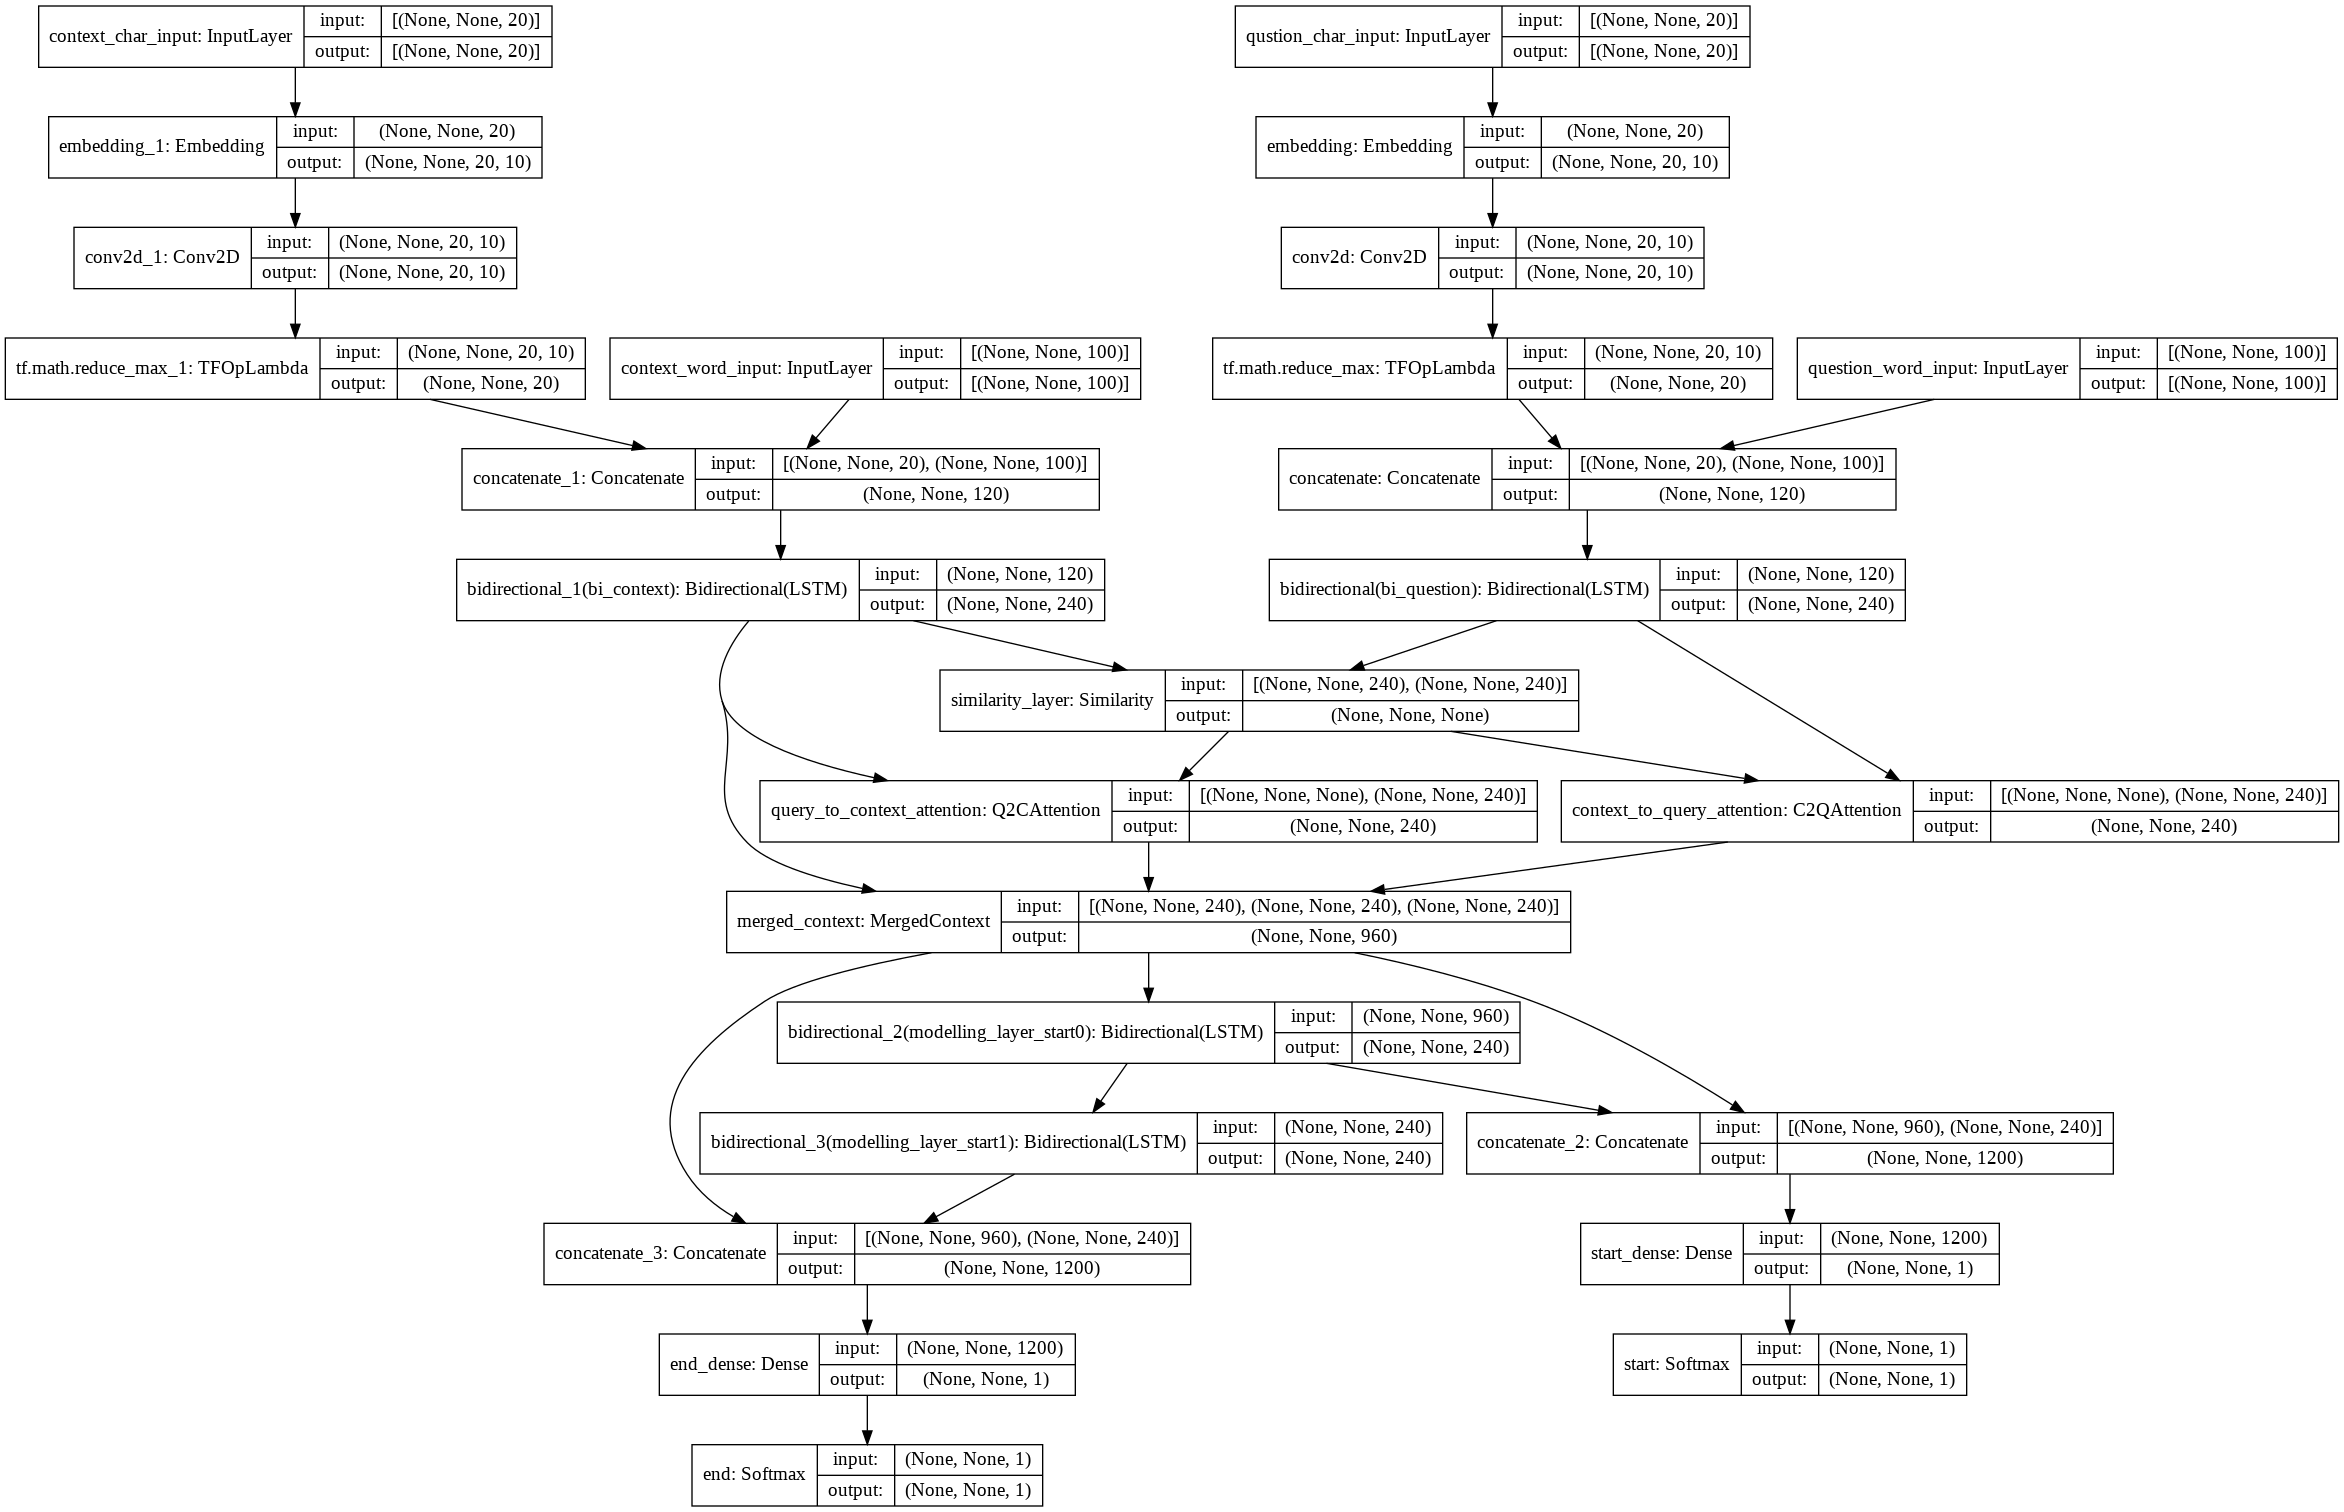

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_char_input (InputLayer) [(None, None, 20)]   0                                            
__________________________________________________________________________________________________
qustion_char_input (InputLayer) [(None, None, 20)]   0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 20, 10) 10700       context_char_input[0][0]         
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 20, 10) 10700       qustion_char_input[0][0]         
______________________________________________________________________________________________

## Training: 

In [ ]:
history = train_model(folder="./models", model=model,
                      model_name="Bidaf", gen=gen, df_val=validate, batch=btch_size, epochs=50,  emb_model=word_emb_model, charVocab=charVocab)

Epoch 1/50
  82/2041 [>.............................] - ETA: 6:33 - loss: 9.8838 - start_loss: 5.5841 - end_loss: 4.2997 - start_categorical_accuracy: 0.0267 - start_DistAccuracy: 0.0000e+00 - end_categorical_accuracy: 0.0636 - end_DistAccuracy: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files 

model.save("Bidaf.D-ATT.h5")
#files.download('BidafCOMP.h5')